In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
%matplotlib inline
np.random.seed(1)
import typing as tp


This is assignment "Convolutional Model: application" of 1st week of course
"Convolutional Neural Networks" from deeplearning.io but rewrote in TF2
(I am also applied some improvements model to increase accuracy)
Dataset is the same as used in original application


Load, exploring and prepare dataset

In [2]:
train_dataset_path = 'datasets/hand_signs_deeplearning_coursera/train_signs.h5'
test_dataset_path = 'datasets/hand_signs_deeplearning_coursera/test_signs.h5'
# dataset split to 90% train 10% test
train_dataset = h5py.File(train_dataset_path, "r")
test_dataset = h5py.File(test_dataset_path, "r")
print(train_dataset["train_set_x"][0].shape)
print(len(train_dataset["train_set_x"]))
print(test_dataset["test_set_x"][0].shape)
print(len(test_dataset["test_set_x"]))
print(len(train_dataset["train_set_y"]))
print(len(test_dataset["test_set_y"]))
print(test_dataset["list_classes"][:])
print("DONE")

(64, 64, 3)
1080
(64, 64, 3)
120
1080
120
[0 1 2 3 4 5]
DONE


In [3]:
# from cnn_utils.py
def load_dataset() -> tp.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train_dataset = h5py.File(train_dataset_path, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(test_dataset_path, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def to_one_hot(matrix : np.ndarray) -> np.ndarray:
    return tf.one_hot(matrix, len(np.unique(matrix)))

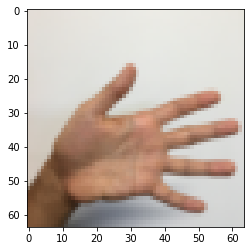

In [4]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
plt.imshow(X_train_orig[0])

In [5]:
# normalize X and one hot encode y
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train = to_one_hot(Y_train_orig[0]) # because Y_*_orig shape (X, 1)
Y_test = to_one_hot(Y_test_orig[0])
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)
(1080, 6)
(120, 6)


Make Model

In [50]:
from tensorflow.keras.initializers import GlorotUniform
def create_model():
    inputs = tf.keras.Input((64,64,3))
    x = tf.keras.layers.Conv2D(8, 4, padding="same", strides=(1,1), activation='tanh',
                               kernel_initializer=GlorotUniform(seed=0), name="CONV1",
                               data_format="channels_last",
                               kernel_regularizer=tf.keras.regularizers.l2(0.005))(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=(8,8), padding="same", name="MAXPOOL1")(x)
    x = tf.keras.layers.Conv2D(16, 2, padding="same", strides=(1,1), activation='tanh',
                               kernel_initializer=GlorotUniform(seed=0),name="CONV2",
                               kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4,4), padding="same",name="MAXPOOL2")(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(6, activation='linear')(x)
    # outputs = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="First_CNN_network")
    model.summary()
    return model

Plot function


In [86]:
def plot_plot(hs):
    fig, ax = plt.subplots(2 , 1, figsize=(10, 10))
    ax[0].plot(hs.history["accuracy"], c="b", label="Train accuracy")
    ax[0].plot(hs.history["val_accuracy"], c="g", label="Test accuracy")
    ax[0].set_title("Train and test accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(hs.history["loss"], c="b", label="Train loss")
    ax[1].plot(hs.history["val_loss"], c="g", label="Test loss")
    ax[1].set_title("Train and test loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[0].legend()
    ax[1].legend()
    plt.subplots_adjust(hspace=0.2)
    plt.show()

Train and Test model


In [61]:
model = create_model()
model.compile(tf.keras.optimizers.Adam(lr=0.009), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics="accuracy")
history = model.fit(X_train, Y_train, batch_size=32, epochs=90, validation_data=(X_test, Y_test))

Model: "First_CNN_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 64, 64, 8)         392       
_________________________________________________________________
MAXPOOL1 (MaxPooling2D)      (None, 8, 8, 8)           0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 8, 8, 16)          528       
_________________________________________________________________
MAXPOOL2 (MaxPooling2D)      (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)           

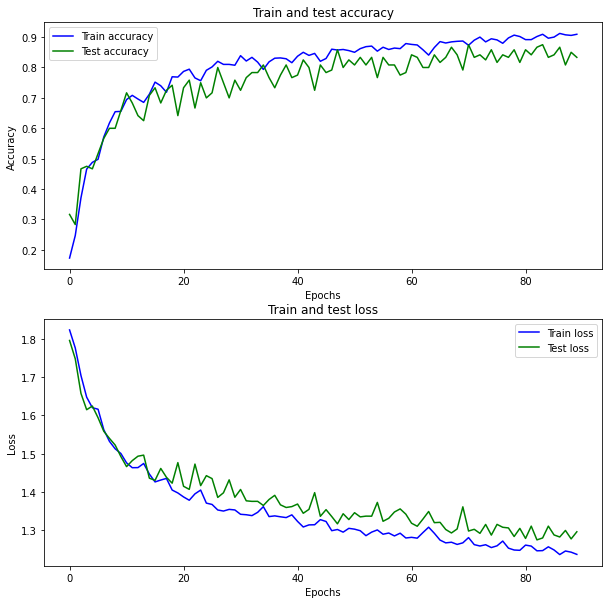

In [87]:
plot_plot(history)

In [45]:
ev_history = model.evaluate(X_test, Y_test, batch_size=64)

2/2 [==============================] - 0s 4ms/step - loss: 0.4325 - accuracy: 0.8750


Current problems:

1) Test accuracy is shaking

Target:
* Accuracy > 0.95
